In [45]:
from gurobipy import *
myModel=Model("SBRP-BB")

In [47]:
import pandas as pd
import numpy as np
data = pd.read_csv('D:\download\BB.csv')
length = len(data['Stop_id'])

In [4]:
# x_ij = 1 if station i to station j is selected (routing variable)
x = myModel.addVars([i for i in range(length)],[j for j in range(length)],vtype=GRB.BINARY, name="x")
# y_i = integer (number of students on bus after station i)
y = myModel.addVars([i for i in range(length)],vtype=GRB.INTEGER, name="y")
# z_i = continuous (time at station i)
z = myModel.addVars([i for i in range(length)], name="z")

In [5]:
c = data['Number']
Q = 50
M = 1000
D = 50
def t(i,j):
    return np.linalg.norm(np.array(data['Latitude'][i],data['Longitude'][i])-np.array(data['Latitude'][j],data['Longitude'][j]))

In [6]:
#dist=[]
#for i in range(1,length):
#    dist.append(t(0,i))
#print(max(dist))
#print(min(dist))

In [7]:
# for every station j (except for the school) exactly one bus
for j in range(1,length):
    myModel.addConstr(quicksum(x[i,j] for i in range(length))==1, name="Constraints1")

for i in range(1,length):
    # for every station i go to a next station j (or school?)
    myModel.addConstr(quicksum(x[i,j] for j in range(length))==1, name="Constraints2")
    # after every station i satisfy capacity
    myModel.addConstr(y[i]<=Q)

In [8]:
for i in range(length):
    for j in range(1,length):
        myModel.addConstr(y[i]-y[j]<= M-M*x[i,j]-c[j], name="Constraints3")
        myModel.addConstr(z[i]+t(i,j)-z[j]<= M*(1-x[i,j]), name="Constraints4")
for i in range(length):        
        myModel.addConstr(z[i]<=D, name="Constraints5")

In [9]:
myModel.addConstr(z[0]==0)
myModel.addConstr(y[0]==0)

<gurobi.Constr *Awaiting Model Update*>

In [10]:
Obj = M* quicksum(x[0,j] for j in range(1, length))+quicksum(t(i,j)*x[i,j] for i in range(length) for j in range(1,length))
myModel.setObjective(Obj,GRB.MINIMIZE)
myModel.write("SS(small).lp")

In [11]:
myModel.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 311 rows, 168 columns and 1037 nonzeros
Model fingerprint: 0x1a0442de
Variable types: 12 continuous, 156 integer (144 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e-02, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 7000.4000000
Presolve removed 82 rows and 41 columns
Presolve time: 0.01s
Presolved: 229 rows, 127 columns, 1346 nonzeros
Variable types: 11 continuous, 116 integer (105 binary)

Root relaxation: objective 3.200000e-01, 80 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.32000    0   28 7000.40000    0.32000   100%     -    0s
H    0     0                    7000.2500000    

In [12]:
route=[]
for i in x:
    if x[i].X==1:
        route.append(i)
        #print(i,x[i].X)
print(route)

[(0, 7), (0, 9), (0, 10), (0, 11), (1, 4), (2, 0), (3, 6), (4, 5), (5, 2), (6, 8), (7, 3), (8, 1), (9, 0), (10, 0), (11, 0)]


In [13]:
print(route[3][0],route[3][1])
#route

0 11


In [14]:
starting=[]
for i in range(len(route)):
    if route[i][0]==0:
        starting.append(route[i])
print(starting)

[(0, 7), (0, 9), (0, 10), (0, 11)]


In [15]:
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] ## set the size of all figures

In [16]:
import math
#def euclidean(x,y): # instead of the Haversine distance <- We should be using Haversine, this is simply a proxy
#    return math.sqrt((x[0]-y[0])**2+(x[1]-y[1])**2)

def haversine(x,y): 
    lon1=x[0]
    lat1=x[1]
    lon2=y[0]
    lat2=y[1]
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    r = 3956 
    return c*r

In [17]:
from itertools import combinations
x=data["Longitude"].tolist() # Longitude corresponds to the x axis.
y=data["Latitude"].tolist() # Latitude corresponds to the y axis.
z=data["Stop_id"].tolist() 
s=data['Nodesize'].tolist()

stations={}
pos={}
for i in range(len(x)):
    stations[z[i]]=(x[i],y[i]) # storing (x,y) information for each zip code
    pos[z[i]]=(x[i],y[i]) # also storing them to position the nodes in the end.

G=nx.Graph() 
addList=[]
for (i,j) in combinations(stations,2):
    distance=haversine(stations[i],stations[j])
    addList.append(distance)
    G.add_node(i,weight=distance)
    G.add_edge(i,j,weight=distance)

In [34]:
starting=[]
for i in range(len(route)):
    if route[i][0]==0:
        starting.append(route[i])
#print(starting)
routes=[]
for i in range(len(starting)):
    routes.append([])
    routes[i].append(starting[i])
#print(routes)
routes_n=0

while len(route)>routes_n:
    for i in range(len(route)):
        for j in range(len(routes)):
            if routes[j][-1][1]!=0:
                if route[i][0]==routes[j][-1][1]:
                    routes[j].append(route[i])
    routes_n=0
    for i in range(len(routes)):
        routes_n+=len(routes[i])

In [43]:
#routes

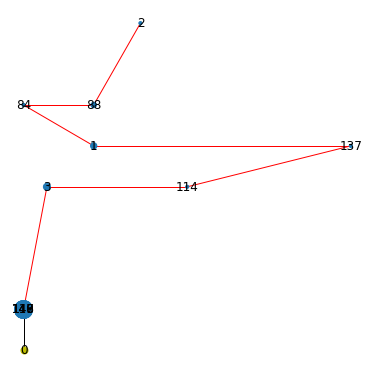

In [41]:
node_list=[0]
nx.draw(G,pos, with_labels=True, node_size=s, width=0) 
nx.draw_networkx_nodes(G,pos,node_size=50,nodelist=node_list,node_color ='y')
nx.draw_networkx_edges(G,pos,edge_color='r',edgelist=routes[0][0:-1])
nx.draw_networkx_edges(G,pos,edge_color='y',edgelist=routes[1][0:-1])
nx.draw_networkx_edges(G,pos,edge_color='b',edgelist=routes[2][0:-1])
nx.draw_networkx_edges(G,pos,edge_color='k',edgelist=routes[3][0:-1])

plt.show()